In [0]:
!pip install pytorch-pretrained-bert

     |████████████████████████████████| 133kB 5.1MB/s 


In [0]:
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')



100%|██████████| 231508/231508 [00:00<00:00, 1160234.02B/s]


In [0]:
text = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + text + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)


['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


In [0]:
# Define a new example sentence with multiple meanings of the word "bank"
text = "After stealing money from the bank vault, the bank robber was seen " \
       "fishing on the Mississippi river bank."

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))


[CLS]           101
after         2,044
stealing     11,065
money         2,769
from          2,013
the           1,996
bank          2,924
vault        11,632
,             1,010
the           1,996
bank          2,924
robber       27,307
was           2,001
seen          2,464
fishing       5,645
on            2,006
the           1,996
mississippi   5,900
river         2,314
bank          2,924
.             1,012
[SEP]           102


In [0]:
# Mark each of the 22 tokens as belonging to sentence "1".
segments_ids = [1] * len(tokenized_text)

print (segments_ids)


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [0]:
# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


100%|██████████| 407873900/407873900 [00:11<00:00, 36153128.45B/s]


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): BertLayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): BertLayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Lin

In [0]:
# Predict hidden states features for each layer
with torch.no_grad():
    encoded_layers, _ = model(tokens_tensor, segments_tensors)


In [0]:
print ("Number of layers:", len(encoded_layers))
layer_i = 0

print ("Number of batches:", len(encoded_layers[layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[layer_i][batch_i][token_i]))



Number of layers: 12
Number of batches: 1
Number of tokens: 22
Number of hidden units: 768


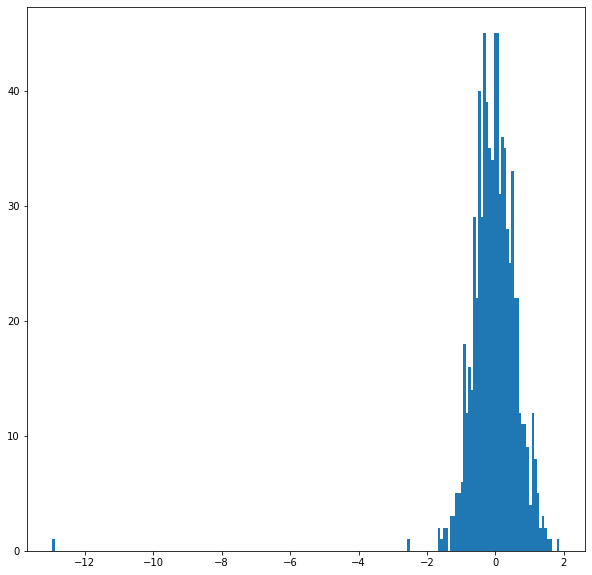

In [0]:
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(10,10))
plt.hist(vec, bins=200)
plt.show()


In [0]:
# `encoded_layers` is a Python list.
print('     Type of encoded_layers: ', type(encoded_layers))

# Each layer in the list is a torch tensor.
print('Tensor shape for each layer: ', encoded_layers[0].size())


     Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 22, 768])


In [0]:
# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor.
token_embeddings = torch.stack(encoded_layers, dim=0)

token_embeddings.size()


torch.Size([12, 1, 22, 768])

In [0]:
# Remove dimension 1, the "batches".
token_embeddings = torch.squeeze(token_embeddings, dim=1)

token_embeddings.size()


torch.Size([12, 22, 768])

In [0]:
# Swap dimensions 0 and 1.
token_embeddings = token_embeddings.permute(1,0,2)

token_embeddings.size()


torch.Size([22, 12, 768])

In [0]:
# `encoded_layers` has shape [12 x 1 x 22 x 768]

# `token_vecs` is a tensor with shape [22 x 768]
token_vecs = encoded_layers[11][0]

# Calculate the average of all 22 token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)


In [0]:
print ("Our final sentence embedding vector of shape:", sentence_embedding.size())
print(sentence_embedding)

Our final sentence embedding vector of shape: torch.Size([768])
tensor([ 3.2873e-02, -2.3461e-01, -7.9924e-02,  3.8905e-01,  8.8793e-01,
         2.1375e-01, -7.8063e-03,  6.2694e-01, -3.2631e-02, -3.4703e-01,
         1.2331e-01, -9.4772e-02, -7.4420e-02,  4.5523e-01, -4.7217e-01,
         1.0344e-01,  3.4667e-01,  1.0410e-01,  5.4372e-01,  6.9113e-02,
        -8.2880e-02,  6.7866e-02,  1.2871e-01,  2.3312e-01,  4.2933e-01,
        -1.2449e-02, -2.1360e-01,  2.2697e-01, -1.2763e-01,  2.8080e-01,
         5.4766e-01, -1.0080e-01,  7.5650e-02, -2.7152e-01, -1.4124e-01,
        -4.0931e-01, -1.9237e-01, -3.9813e-02, -2.3175e-01,  3.3040e-01,
        -3.8484e-01, -3.7469e-01, -2.4978e-01,  3.2707e-01, -9.0552e-04,
        -4.4285e-01,  7.6833e-02, -4.4618e-02,  1.9808e-02,  7.4679e-02,
        -3.2986e-01,  8.2114e-01, -7.6256e-01, -4.1610e-04,  8.9090e-02,
         5.3472e-01, -3.8244e-01, -6.0184e-01, -8.3941e-02, -9.6009e-02,
         3.7689e-01, -2.5287e-01,  4.6429e-01, -5.4761e-01, 